### Evolving Network Analysis - January 2018
#### <i>Abdel K. Bokharouss, Joris Rombouts, Bart van Helvert, Remco Surtel</i>

#### Imports, preparation, and creating the graphs

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import datetime
import tkinter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [2]:
temp_nw = pd.read_table("./data/tgraph_real_wikiedithyperlinks.txt", header = None, sep = " ",
                       names = ["src", "trg", "start", "end"])

In [3]:
temp_nw.head()

,src,trg,start,end
0,1,6,1028243088,1120917090
1,1,8,1029885647,1136791625
2,1,9,1029885647,1136791625
3,1,3,1028243088,1143227562
4,1,3,1146727453,1148998304


In [4]:
temp_nw['start'] = pd.to_datetime(temp_nw['start'], unit = 's') #convert Unix timestamps to date time, utc = 0
temp_nw['end'] = pd.to_datetime(temp_nw['end'], unit = 's')

In [5]:
#test function for unix time stamps to datetime
print(
    datetime.datetime.fromtimestamp(
        int("1028243088")
    ).strftime('%Y-%m-%d %H:%M:%S')
)

2002-08-02 01:04:48


In [6]:
temp_nw.head()

,src,trg,start,end
0,1,6,2002-08-01 23:04:48,2005-07-09 13:51:30
1,1,8,2002-08-20 23:20:47,2006-01-09 07:27:05
2,1,9,2002-08-20 23:20:47,2006-01-09 07:27:05
3,1,3,2002-08-01 23:04:48,2006-03-24 19:12:42
4,1,3,2006-05-04 07:24:13,2006-05-30 14:11:44


In [7]:
temp_nw.shape

(4729035, 4)

Let's create a timestamp for every year: $T_i = $ 2002$+i$-01-01 00:00:00.

In [8]:
# Create timestamps
dTime={}
for x in range(0,11):
    year = 2002 + x
    T = datetime.datetime(year, 1, 1, 0, 0, 0)
    dTime["T{0}".format(x)]=T
dTime

{'T0': datetime.datetime(2002, 1, 1, 0, 0),
 'T1': datetime.datetime(2003, 1, 1, 0, 0),
 'T10': datetime.datetime(2012, 1, 1, 0, 0),
 'T2': datetime.datetime(2004, 1, 1, 0, 0),
 'T3': datetime.datetime(2005, 1, 1, 0, 0),
 'T4': datetime.datetime(2006, 1, 1, 0, 0),
 'T5': datetime.datetime(2007, 1, 1, 0, 0),
 'T6': datetime.datetime(2008, 1, 1, 0, 0),
 'T7': datetime.datetime(2009, 1, 1, 0, 0),
 'T8': datetime.datetime(2010, 1, 1, 0, 0),
 'T9': datetime.datetime(2011, 1, 1, 0, 0)}

Now that we have these timestamps, let's generate some graphs, $G_0, G_1, G_2, G_3, G_4, G_5, G_6, G_7, G_8, G_9$, each containing only the edges that appear between $T_i$ and $T_{i+1}$ for $G_i$.

In [10]:
# Create DataFrames for every timestamp
dfG={}
for x in range(0,10):
    T0 = "T{0}".format(x)
    T1 = "T{0}".format(x+1)
    T0 = dTime.get(T0)
    T1 = dTime.get(T1)
    df_G = temp_nw.copy()
    df_G = df_G[((df_G['start'] >= T0) & (df_G['start'] < T1)) | ((df_G['end'] > T0) & (df_G['end'] <= T1)) | 
                ((df_G['start'] < T0) & (df_G['end'] > T1))]
    dfG["df_G{0}".format(x)]=df_G
    print("df_G{0}".format(x) + ": " + str(df_G.shape))

df_G0: (56459, 4)
df_G1: (210603, 4)
df_G2: (502719, 4)
df_G3: (1115759, 4)
df_G4: (1685662, 4)
df_G5: (1758664, 4)
df_G6: (1618639, 4)
df_G7: (1331689, 4)
df_G8: (960662, 4)
df_G9: (443777, 4)


In [11]:
#Create a DataFrame with the amount of edges during every period, so we can visualize it.
lstEdges = list()
lstTime = list()
for x in range(0,10):
    T = "{0}".format(2002+x) + " - " + "{0}".format(2002+x+1) 
    lstTime.append(T)
    df = "df_G{0}".format(x); df = dfG.get(df)
    lstEdges.append(df.shape[0])
edges = pd.DataFrame({'Time': lstTime, 'Edges': lstEdges})
cols = edges.columns.tolist()
cols = cols[-1:] + cols[:-1]
edges = edges[cols]
edges

,Time,Edges
0,2002 - 2003,56459
1,2003 - 2004,210603
2,2004 - 2005,502719
3,2005 - 2006,1115759
4,2006 - 2007,1685662
5,2007 - 2008,1758664
6,2008 - 2009,1618639
7,2009 - 2010,1331689
8,2010 - 2011,960662
9,2011 - 2012,443777


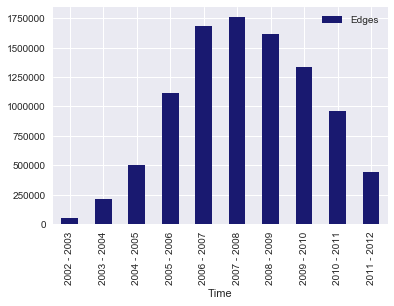

In [12]:
edges.plot.bar(x = 'Time', color='midnightblue');
plt.show()

So we can see that the amount of edges quickly increases starting in 2002, and reaches a peak in 2007. The amount of edges then slowly decreases until 2012.

In [13]:
# Initialize a directed graph G from each of the given pandas dataframes.
dG={}
for x in range(0,10):
    G = "df_G{0}".format(x)
    G = dfG.get(G)
    G = nx.from_pandas_dataframe(G, 'src', 'trg', edge_attr=None, create_using=nx.DiGraph())
    dG["G{0}".format(x)]=G

## Assortativity

In [14]:
# Run the Assortativity algorithm from networkx. Because G is a directed graph, we must specify the degree types for source (x) 
# and target (y) nodes.
# Returns float; Assortativity of graph by degree.
dAssort={}
for x in range(0,10):
    G = "G{0}".format(x); G = dG.get(G)
    assortativity = nx.degree_assortativity_coefficient(G, x='out', y='in'); print("r" + str(x) + ": " + str(assortativity))
    dAssort["Assortativity{0}".format(x)]=assortativity

r0: -0.149407576492
r1: -0.0720752198269
r2: -0.0675476326705
r3: -0.0823281767082
r4: -0.0774179499571
r5: -0.0734198510666
r6: -0.0706912069773
r7: -0.0698025686817
r8: -0.0711758093667
r9: -0.0986373068886


Positive values of the assortativity coefficient $r$ indicate a correlation between nodes of similar degree, while negative values indicate relationships between nodes of different degree. In general, $r$ lies between -1 and 1. When $r=1$, the network is said to have perfect assortative mixing patterns, when $r=0$ the network is non-assortative, while at $r=-1$ the network is completely disassortative. 

Our values, $r_i \approx -0.075 \pm 0.01$, indicate that the graphs $G_i$ are mostly non-assortative. In other words, there is no indication that nodes with a high degree are more likely to be linked to other nodes with a high degree. Furthermore, there is also no indication that nodes with a low degree are more likely to be linked to nodes with a high degree. The edges between nodes do not appear to be correlated to the degrees of the nodes in any way.

Furthermore, there aren't any large differences between any of the time ranges, and all of the results are similar to the one that the found for the original, complete graph, $r \approx -0.08$. The only relatively large differences can be seen in the the first (2002 - 2003) and last (2011 - 2012) time ranges, where $r_0 \approx -0.149, r_9 \approx -0.099$. This only makes sense, because these time ranges contain the least amount of edges and nodes, thus the results are more volatile here. Apart from these two time ranges though, the differences are hardly significant.

In [15]:
# Run the average neighbour degree algorithm from networkx. 
# Returns dict; A dictionary keyed by node with average neighbours degree value.
dd={}
for x in range(0,10):
    G = "G{0}".format(x); G = dG.get(G)
    AND = nx.average_neighbor_degree(G, source='out', target='in') #AND = Average Neighbour Degree
    print("Average neighbour degree dictorionary (" + str(2002+x) + " - " + str(2002+x+1) + "): stored in dd(d" + str(x) + ")")
    dd["d{0}".format(x)]=AND

Average neighbour degree dictorionary (2002 - 2003): stored in dd(d0)
Average neighbour degree dictorionary (2003 - 2004): stored in dd(d1)
Average neighbour degree dictorionary (2004 - 2005): stored in dd(d2)
Average neighbour degree dictorionary (2005 - 2006): stored in dd(d3)
Average neighbour degree dictorionary (2006 - 2007): stored in dd(d4)
Average neighbour degree dictorionary (2007 - 2008): stored in dd(d5)
Average neighbour degree dictorionary (2008 - 2009): stored in dd(d6)
Average neighbour degree dictorionary (2009 - 2010): stored in dd(d7)
Average neighbour degree dictorionary (2010 - 2011): stored in dd(d8)
Average neighbour degree dictorionary (2011 - 2012): stored in dd(d9)


In [16]:
# Creating DataFrames for each of the dictionaries
ddf={}
for x in range(0,10):
    avgNeighbourDegree = "d{0}".format(x); avgNeighbourDegree = dd.get(avgNeighbourDegree)
    df = pd.DataFrame.from_dict(avgNeighbourDegree, orient='index')
    df.columns = ['Avg neighbour degree']
    df['Node'] = df.index
    degree = list()
    nodes = df.index
    G = "G{0}".format(x); G = dG.get(G)
    for node in nodes:
        deg = G.degree(node)
        degree.append(deg)
    df['Degree'] = degree
    cols = df.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df = df[cols]
    print("Created DataFrame df" + str(x) + " for time range (" + str(2002+x) + " - " + str(2002+x+1) + ")")
    ddf["df{0}".format(x)]=df

Created DataFrame df0 for time range (2002 - 2003)
Created DataFrame df1 for time range (2003 - 2004)
Created DataFrame df2 for time range (2004 - 2005)
Created DataFrame df3 for time range (2005 - 2006)
Created DataFrame df4 for time range (2006 - 2007)
Created DataFrame df5 for time range (2007 - 2008)
Created DataFrame df6 for time range (2008 - 2009)
Created DataFrame df7 for time range (2009 - 2010)
Created DataFrame df8 for time range (2010 - 2011)
Created DataFrame df9 for time range (2011 - 2012)


In [17]:
# Example (2002 - 2003)
ddf.get('df0').head()

,Node,Degree,Avg neighbour degree
1,1,16,20.416667
6,6,2,0.000000
8,8,4,0.000000
9,9,75,95.641026
3,3,21,0.000000


In [18]:
# Creating a DataFrame to analyze the average average neighbour degree over time
lstDegree = list()
for x in range(0,10):
    df = "df{0}".format(x); df = ddf.get(df)
    lstDegree.append(df['Avg neighbour degree'].mean())
avgDegree = pd.DataFrame({'Time': lstTime, 'Avg degree': lstDegree})
cols = avgDegree.columns.tolist()
cols = cols[-1:] + cols[:-1]
avgDegree = avgDegree[cols]
avgDegree

,Time,Avg degree
0,2002 - 2003,23.958797
1,2003 - 2004,24.370012
2,2004 - 2005,54.258272
3,2005 - 2006,208.937909
4,2006 - 2007,310.030716
5,2007 - 2008,240.336918
6,2008 - 2009,219.782257
7,2009 - 2010,220.095069
8,2010 - 2011,116.577892
9,2011 - 2012,113.858715


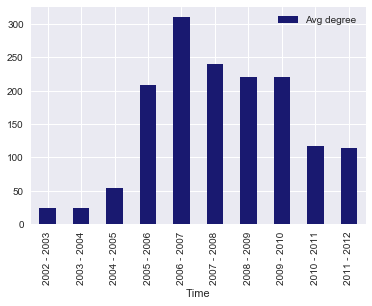

In [19]:
avgDegree.plot.bar(x = 'Time', color='midnightblue');
plt.show()

What's interesting from this plot, is that from 2008-2009 to 2009-2010, as well as from 2010-2011 to 2011-2012, the average of the average neighbour degree doesn't decrease, it remains almost the same, whereas we would expect it to keep gradually decreasing as the amount of edges decreases. We believe that this could be the result of the way that we create our graphs. We create our graphs by reading a list of edges, thus, by excluding edges that did not occur in some specific time range, we also leave out the nodes that would have had this edge, unless these nodes have another edge that did occur in the time range. Thus, by excluding these nodes, we create a graph that has less nodes than the one before it did. This means that, even though the amount of edges in the new graph is lower, the average degree can still be higher or equal, because there are less nodes that these edges are distributed over.

2002 - 2003


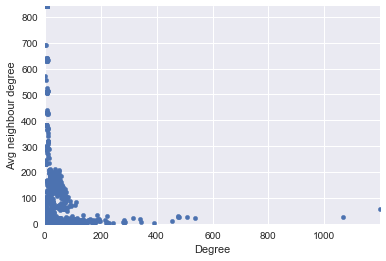

2003 - 2004


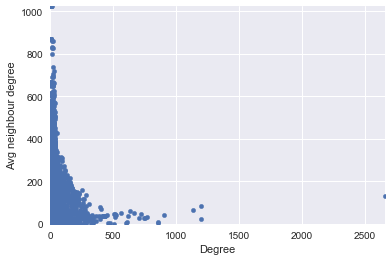

2004 - 2005


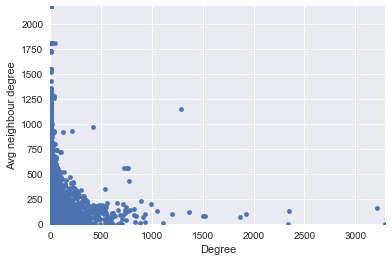

2005 - 2006


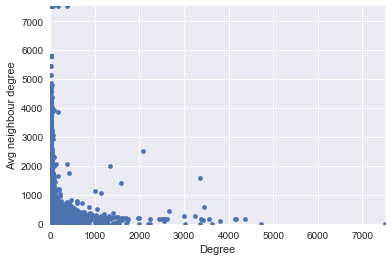

2006 - 2007


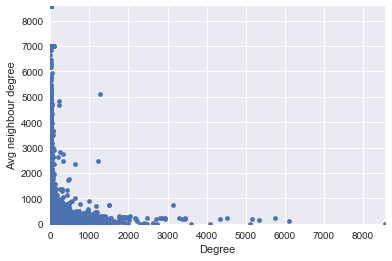

2007 - 2008


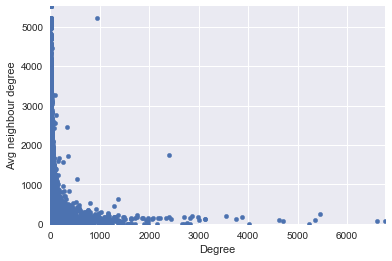

2008 - 2009


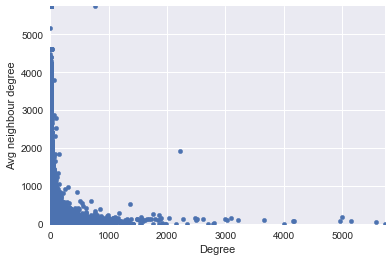

2009 - 2010


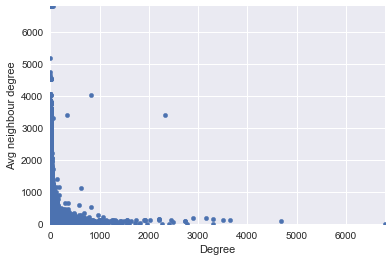

2010 - 2011


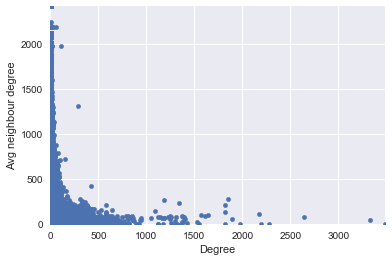

2011 - 2012


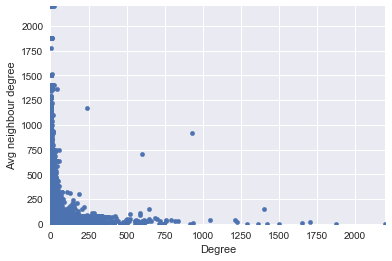

In [20]:
for x in range(0,10):
    df = "df{0}".format(x); df = ddf.get(df)
    T = lstTime[x]
    print(T)
    df.plot(kind='scatter', x='Degree', y='Avg neighbour degree', s=20);
    plt.xlim(0, df['Degree'].max())
    plt.ylim(0, df['Avg neighbour degree'].max())
    plt.show()

These plots show that, even though the amount of edges and the degrees of the nodes change over time, the relation between a node's degree and its average neighbour degree remains constant. The relation, and therefore our conclusion, has remained the same as in the static (non-temporal) analysis: 

We can see that most nodes have a low degree, that's why nodes are mostly on the left side of the graph. However, we can also see that, of the few nodes that do have a high degree, their average neighbour still has a low degree (shown by the nodes scattered along the X-axis). Also, nodes with a low degree can still be linked to nodes that have a high degree (shown by the nodes scattered along the Y-axis). If the graph was assortative, we would expect a line through $y=x$, and if the graph was disassortative, we would expect a line through $y=-x$. This plot, however, shows that the graphs $G_i$ are indeed all non-assortative, as the assortativity coefficients predicted.

To link this back to the subject of this exercise, the wiki page, let's say that a link is added from a wiki page $page 1$ to another wiki page, $page 2$. Then, because our network is non-assortative, we cannot say anything about what the degree of $page 2$ is likely to be, in terms of the degree of $page 1$.

For instance, if we assume that the network was assortative, and we know that $page 1$ has a high degree (i.e. it links to many other pages), then we could say that it is likely that $page 2$ also has a high degree. Or, if the network was disassortative, we could say that it is likely for $page 2$ to have a low degree. However, because our network is non-assortative, we cannot make any useful conclusions. 

This property is likely caused by the fact that wiki pages are linked to solely based on their content, and not based on any additional properties, like their degree. For example, if a wiki page is being written about temporal network analysis, the writer will likely link to a wiki page explaining what a temporal network is so that he does not have to add duplicate information, regardless of how many links this wiki page might contain.